In [1]:
model_name = "SniffingNetwork"
stage = "Production"
run_name = "three neurons kitchen only, 40 dense"
description = "tiny network for three neurons with kitchen data only"

data_classes = ["Sniffing", "Background", "Quiet"]

In [2]:
# Code copied from BuildModel_twoOutputNeurons. Maybe merge?
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
import tensorflow.experimental.numpy as tnp
import glob

def generate_spectrogram(file_path, label):
    # does not scale as sniffing should be the same independent of background level
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype=tf.int16)
    audio = tf.cast(audio_tensor[:], tf.float32)
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True)
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    # Not sure whether the log is a good idea...
    spectrogram = tnp.log10(spectrogram + 1e-6)
    return spectrogram, label

def prepare_data(dir, value):
    filePath = os.path.join(dir, "*.wav")
    files = tf.data.Dataset.list_files(filePath)
    values = tf.zeros(len(files)) if value == 0 else tf.ones(len(files))
    data = tf.data.Dataset.zip((files, tf.data.Dataset.from_tensor_slices(values)))
    spectrogramData = data.map(generate_spectrogram)
    return spectrogramData

def batch_prefetch(dataSet):
    dataSet = dataSet.batch(16)
    dataSet = dataSet.prefetch(8)
    return dataSet

def generate_dataset(train_or_test, classes):
    class_counts = []
    data_sets = []
    for index, current_class in enumerate(classes):
        current_data_dir = f"data/{train_or_test}/{current_class}"
        current_data = prepare_data(current_data_dir, index)
        data_sets.append(current_data)
        current_number = current_data.cardinality().numpy()
        class_counts.append(current_number)
        print(f"{current_class} Datasets: {current_number}")

    if correct_class_imbalance:
        smallest_data_count = min(class_counts)
        for index, data_set in enumerate(data_sets):
            corrected_data = data_set.shuffle(class_counts[index]).take(smallest_data_count)
            data_sets[index] = corrected_data
            corrected_number = corrected_data.cardinality().numpy()
            print(f"Corrected {classes[index]} Datasets: {corrected_number}")
    combined_data = data_sets[0]
    for next_data in data_sets[1:]:
        combined_data = combined_data.concatenate(next_data)
    combined_data = combined_data.cache()
    return combined_data.shuffle(buffer_size=combined_data.cardinality().numpy())

def representative_data_gen():
    data = generate_dataset(train_or_test="train", classes=data_classes)
    train = batch_prefetch(data)
    repr_samples, repr_labels = train.as_numpy_iterator().next()
    yield [repr_samples]

In [3]:
import mlflow.keras
import os
import pathlib
import tensorflow as tf

mlflow.set_experiment("tinyML")
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    model_uri=f"models:/{model_name}/{stage}"
    mlflow.log_param("URI", model_uri)
    mlflow.log_param("Description", description)

    correct_class_imbalance = True

    # TODO Don't make a local copy
    model = mlflow.keras.load_model(model_uri)
    savedModelDir = os.path.join(os.getcwd(), "sniffing_model/1/")
    tf.saved_model.save(model, savedModelDir)
    converter = tf.lite.TFLiteConverter.from_saved_model(savedModelDir)

    # Post Training Quantization
    # https://www.tensorflow.org/lite/performance/post_training_quantization
    # Integer with float fallback (using default float input/output)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen

    # Integer only
    # doesn't work here, as I have float32 input and want an output 0<= x <= 1
    # atomic14_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # atomic14_converter.inference_input_type = tf.int8  # or tf.uint8
    # atomic14_converter.inference_output_type = tf.int8

    tflite_model = converter.convert()

    tflite_model_file = pathlib.Path('./tflite_models/model.tflite')
    tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Joerg\Documents\tmp\SniffingDetector\Detecting\NeuralNetwork\sniffing_model/1/assets


INFO:tensorflow:Assets written to: C:\Users\Joerg\Documents\tmp\SniffingDetector\Detecting\NeuralNetwork\sniffing_model/1/assets


Sniffing Datasets: 213
Background Datasets: 522
Quiet Datasets: 227
Corrected Sniffing Datasets: 213
Corrected Background Datasets: 213
Corrected Quiet Datasets: 213


Run xxd -i model.tflite > model_data.cc in git bash
or install
https://sourceforge.net/projects/xxd-for-windows/

In [4]:
!C:\Users\Joerg\Documents\Programs\xxd.exe -i .\tflite_models\model.tflite > .\tflite_models\model_data.cc

In [5]:
# evaluate the model
def generate_spectrogram_only(file_path):
    # does not scale as sniffing should be the same independent of background level
    audio_tensor = tfio.audio.AudioIOTensor(file_path, dtype=tf.int16)
    audio = tf.cast(audio_tensor[:], tf.float32)
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True)
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    # Not sure whether the log is a good idea...
    spectrogram = tnp.log10(spectrogram + 1e-6)
    return spectrogram


# make a single based on tflite prediction
def make_tflite_prediction(one_second_file):
    spectrogram = generate_spectrogram_only(one_second_file)
    interpreter.set_tensor(input_index, [spectrogram])
    interpreter.invoke()
    tflite_result = interpreter.get_tensor(output_index)
    return tflite_result


In [6]:
# prepare tfMicro Interpreter
interpreter = tf.lite.Interpreter(model_path="./tflite_models/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_index = input_details[0]['index']
output_index = output_details[0]['index']

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

predicted_labels = []
true_labels = []
with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    mlflow.log_artifact('./tflite_models/model_data.cc')
    for index, data_class in enumerate(data_classes):
        for audio_file in glob.glob(f"./data/test/{data_class}/*.wav"):
            tf_lite_result = make_tflite_prediction(audio_file)[0]
            prediction = np.argmax(tf_lite_result)
            predicted_labels.append(prediction)
            true_labels.append(index)

    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)


[[ 36   5   0]
 [ 32 111   0]
 [  0   0  53]]


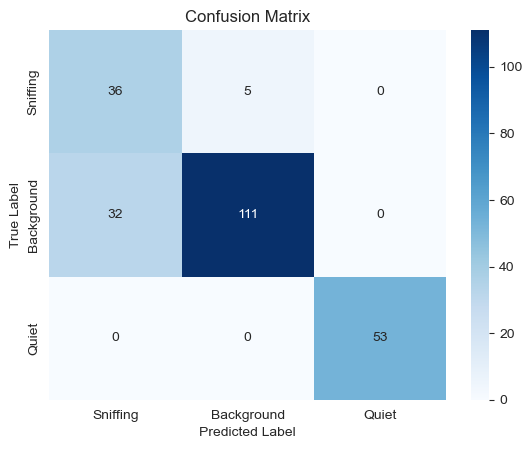

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

with mlflow.start_run(run_id=run_id, run_name=run_name) as run:
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=data_classes, yticklabels=data_classes)
    # Set the title and axis labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Show the plot
    fig = plt.gcf()
    mlflow.log_figure(fig, 'ConfusionMatrix.png')
    plt.show()

In [9]:
mlflow.end_run()